In [1]:
from __future__ import absolute_import, division
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import pickle
import copy
import scipy

import matplotlib.pyplot as plt
import itertools

# from black import out
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.special import logsumexp
from autograd import grad, jacobian
from autograd import elementwise_grad as egrad
from autograd.misc.flatten import flatten
from autograd.misc.optimizers import adam

# Load Model

In [2]:
model_orig = tf.keras.models.load_model("tc1/model")
weights = model_orig.get_weights()
layer_sizes = np.array([3,3,3,3])
ws = []
for w in weights:
    ws = ws + list(w.flatten())
init_params = np.array(ws)

2022-05-18 11:27:43.703702: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def neural_net_predict(params, inputs, architechture):

    idx = 0
    num_layers = architechture.shape[0] - 1
    for l in range(num_layers):
        inp_dim = architechture[l]
        out_dim = architechture[l + 1]
        num_param = inp_dim * out_dim + out_dim
        W = params[idx : idx + inp_dim * out_dim]
        b = params[idx + inp_dim * out_dim : idx + inp_dim * out_dim + out_dim]
        outputs = np.dot(inputs, W.reshape((inp_dim, out_dim))) + b
        inputs = np.maximum(np.zeros((outputs.shape[0],outputs.shape[1])), outputs)
        idx = idx + inp_dim * out_dim + out_dim

    return outputs

def neural_return_weights_pert(params, architechture):

    idx = 0
    num_layers = architechture.shape[0] - 1
    weights = []
    bias = []
    for l in range(num_layers):
        inp_dim = architechture[l]
        out_dim = architechture[l + 1]
        W = params[idx : idx + inp_dim * out_dim].reshape((inp_dim, out_dim))
        b = params[idx + inp_dim * out_dim : idx + inp_dim * out_dim + out_dim]
        idx = idx + inp_dim * out_dim + out_dim
        weights.append(W)
        bias.append(b)

    return weights, bias

# Load Dataset

In [4]:
def original_data_loader():
    if not os.path. exists ("tc1/data/input_output_data_tc1.pickle"):
        raise ImportError(
            "path data/input_output_data_tc1.pickle does not exist!"
        )
    with open ("tc1/data/input_output_data_tc1.pickle", "rb") as data:
        dataset = pickle.load (data)
    return dataset[0], dataset[1], dataset[2], dataset[3]

In [5]:
x_train, y_train, x_test, y_test = original_data_loader()

# Calculate Hessian

### Cost Function

In [6]:
def soft_plus(x, t=10.): # (1/t) * Ln(1+exp(t*x))
    return (1/t)*np.log(1+np.exp(t*x))

Constraint cost:
\begin{aligned}
\sum^{N}_{n=1}\sum^{C}_{c=1} g(A_c y_n-b_c,t)
\end{aligned}
where $g$ is a soft plus function
\begin{aligned}
g(x,t) = \frac{1}{t}\ln{(1+e^{tx})},
\end{aligned}
$C$ is the number of constraints, $t$ is the approximation coefficient, and $N$ is the number of samples.

In [7]:
def dist_loss(params):
    A = np.array([[-0.70710678,  0.70710678],
       [ 0.70710678,  0.70710678],
       [-0.70710678, -0.70710678],
       [ 0.70710678, -0.70710678]])
    b = np.array([[ 1.225     ],
       [ 4.76053391],
       [-2.31053391],
       [ 1.225     ]])
    y_pred = neural_net_predict(params, x_train, layer_sizes)
    const = np.matmul(A,y_pred[:,0:2].T) - b
    loss = np.sum(
#         np.maximum(np.zeros((const.shape[0],const.shape[1])), const)
        soft_plus(const,10)
    )
    return loss

In [8]:
def objective(params):
    return np.sum((neural_net_predict(params, x_train, layer_sizes) - y_train) ** 2)

###  Hessian

In [9]:
hessian_dist = jacobian(egrad(dist_loss))(init_params)
hessian_loss = jacobian(egrad(objective))(init_params)

In [10]:
from numpy import linalg as la
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

### A function to make a matrix PSD

In [11]:
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

In [12]:
B = nearestPD(hessian_dist)
isPD(B)

True

### Find Sparse Eigenvectors for Hessian

In [13]:
def get_weight_range(arch, layer):
    idx = 0
    num_layers = arch.shape[0] - 1
    for l in range(0, layer + 1):
        idx_range = [idx]
        inp_dim = arch[l]
        out_dim = arch[l + 1]
        idx = idx + inp_dim * out_dim + out_dim
        idx_range.append(idx)
        
    return idx_range
def sparse_eigenvector_reduction(H_dist, H_loss, arch, layer, num_non_sparse):
    # get layer indices 
    idx_range = get_weight_range(arch, layer)
    idx_list = [i for i in range(idx_range[0], idx_range[1])]
    
    # test all num_non_sparse combinations of weights
    # and check which one maximizes w.T*H*w
    max_cost = 0
    iteration = 1
    all_iters = int(
        scipy.special.factorial(len(idx_list))/
        (
            scipy.special.factorial(num_non_sparse)*
            scipy.special.factorial(len(idx_list)-num_non_sparse)
        )
    )
    costs = []
    losses = []
    for L in range(num_non_sparse,num_non_sparse+1):
        for subset in itertools.combinations(idx_list,L):
            print(f"iteration: {iteration}/{all_iters}")
            sparse_idx = list(subset)
            H_reduced = H_dist[sparse_idx][:,sparse_idx]
            
#             if not isPD(H_reduced):
#                 H_reduced = nearestPD(H_reduced)
            
            ei, vi = np.linalg.eig(H_reduced)
            vec_reduced = vi[:,0]
            vec = np.zeros(H_dist.shape[0])
            idx = 0
            for el in sparse_idx:
                vec[el] = vec_reduced[idx]
                idx += 1
            cost = np.matmul(vec,np.matmul(H_dist,vec))
            costs.append(cost)
            losses.append(np.matmul(vec,np.matmul(H_loss,vec)))
            if cost >= max_cost:
                selected_vec = vec
                max_cost = cost
            iteration += 1
    print(f"max cost: {max_cost}")
    return selected_vec, costs, losses

In [14]:
eigenvector, cost_vec, loss_vec = sparse_eigenvector_reduction(
    hessian_dist, 
    hessian_loss, 
    layer_sizes, 0, 7)

iteration: 1/792
iteration: 2/792
iteration: 3/792
iteration: 4/792
iteration: 5/792
iteration: 6/792
iteration: 7/792
iteration: 8/792
iteration: 9/792
iteration: 10/792
iteration: 11/792
iteration: 12/792
iteration: 13/792
iteration: 14/792
iteration: 15/792
iteration: 16/792
iteration: 17/792
iteration: 18/792
iteration: 19/792
iteration: 20/792
iteration: 21/792
iteration: 22/792
iteration: 23/792
iteration: 24/792
iteration: 25/792
iteration: 26/792
iteration: 27/792
iteration: 28/792
iteration: 29/792
iteration: 30/792
iteration: 31/792
iteration: 32/792
iteration: 33/792
iteration: 34/792
iteration: 35/792
iteration: 36/792
iteration: 37/792
iteration: 38/792
iteration: 39/792
iteration: 40/792
iteration: 41/792
iteration: 42/792
iteration: 43/792
iteration: 44/792
iteration: 45/792
iteration: 46/792
iteration: 47/792
iteration: 48/792
iteration: 49/792
iteration: 50/792
iteration: 51/792
iteration: 52/792
iteration: 53/792
iteration: 54/792
iteration: 55/792
iteration: 56/792
i

/var/folders/7v/7wknzt0d797gn2p62b8394yc0000gn/T/ipykernel_81274/2579896879.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  vec[el] = vec_reduced[idx]


**Idea:**
\begin{aligned}
&\max_{w} &&w^THw\\
&s.t. && w^Tw=1\\
&&& \lVert w\rVert^l_0 = k &&& k\leq \dim(w^l)\\
&&& \lVert w\rVert^{l'}_0 = 0 
\end{aligned}

Finding the optimal solution $w$  for all combinations of $k$ weights in layer $l$.

**Note:** This OPT is a **combinatorial problem** but for a specified sparse components of $w$, $H$ size will be reduced to the dimension of sparse (nonzero) components. The new problem is now finding the eigenvector of the largest eigenvalue for the reduced $H$.

So, this algorithm iterate of all combinations of $k$ weights in layer $l$ and extract the component with the largest eigenvalue that corresponds to the maximum cost.

## Interesting Observation!

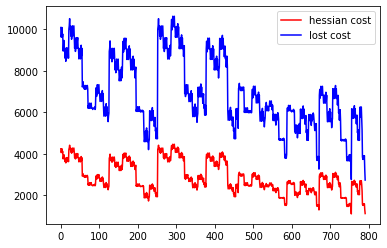

In [15]:
plt.plot(cost_vec, color='r', label="hessian cost")
plt.plot(loss_vec, color='b', label="lost cost")
plt.legend()

The eigenvalue index with the lowest loss 1


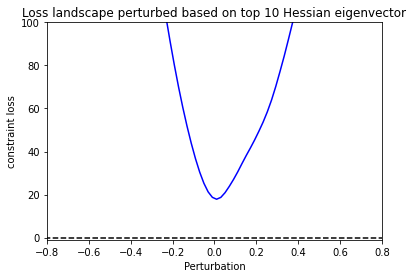

In [16]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-1, 1, 100).astype(np.float32)

loss_list = []
num_eig = 10
# model_perb = model_perb.cuda()
lowest = np.inf
for i in range(1):
    for lam in lams:
        par = init_params + lam * eigenvector
        loss_list.append(dist_loss(par))
    plt.plot(lams, loss_list, color = (i/(num_eig+1),i/(num_eig+1),1))
    if min(loss_list) < lowest:
        lowest_idx = i
        lowest = min(loss_list)
    loss_list = []
    
plt.plot(np.array([-1, 1]), np.array([0, 0]), 'k--')
plt.ylabel('constraint loss')
plt.xlabel('Perturbation')
plt.ylim([-1,100])
plt.xlim([-0.8,.8])
plt.title('Loss landscape perturbed based on top 10 Hessian eigenvector')
print(f"The eigenvalue index with the lowest loss {lowest_idx+1}")

In [17]:
w_pert, bias_pert = neural_return_weights_pert(eigenvector, layer_sizes)

In [18]:
w_pert

[array([[-0.5775848 ,  0.        ,  0.31552058],
        [-0.59826201,  0.        ,  0.32506159],
        [-0.21182191,  0.        ,  0.        ]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])]

In [19]:
bias_pert

[array([-0.21182191,  0.        ,  0.11628853]),
 array([0., 0., 0.]),
 array([0., 0., 0.])]

In [20]:
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
import pyomo.environ as pyo
import pyomo.gdp as pyg
from pyomo.gdp import *
import pickle
import itertools
from scipy.spatial import ConvexHull
#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

#  Generate Data

#### Derive output constraints

In [21]:
## polygon vertices
poly = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly2 = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
x_poly2, y_poly2 = poly2.exterior.xy

## rotate input points in-place by pi/4 radian
transform1 = np.array([[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]])  # transformation matrix 1
transform2 = np.array([[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]])  # transformation matrix 2
rotate = np.array([[cos(pi / 4), -sin(pi / 4), 0], [sin(pi / 4), cos(pi / 4), 0], [0, 0, 1]])  # rotation matrix

inp = np.array([[1.25, 3.75, 3.75, 1.25],[1.25, 1.25, 3.75, 3.75],[1, 1 , 1, 1]])
out = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), inp)
poly3 = Polygon([(out[0, 0], out[1, 0]), (out[0, 1], out[1, 1]), (out[0, 2], out[1, 2]), (out[0, 3], out[1, 3])])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]
b = -eqs[0:eqs.shape[0],-1]
print(A)
print(b)

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
[ 1.25        4.78553391 -2.28553391  1.25      ]


### Replicate the Original NN

#### Classes (NN with Numpy)

In [22]:
class Dense:
    def __init__(self, nin, nout):
        self.weights = np.random.rand(nin, nout) * 2 - 1
        self.bias = np.random.rand(nout) * 2 - 1
        
    def _relu(self, x):
        return np.maximum(x, 0)
    
    def __call__(self, x, relu=False):
        x = x @ self.weights + self.bias
        if relu:
            x = self._relu(x)
            
        return x

    def set_variables(self, weights=None, bias=None):
        if weights is not None:
            self.weights[:] = weights[:]
            
        if bias is not None:
            self.bias[:] = bias[:]
            
class MLP:
    def __init__(self, nin, uout, uhidden):
        self.num_layer = len(uhidden)+1
        prev = nin
        self.layers = []
        for u in uhidden:
            self.layers.append(Dense(prev, u))
            prev = u
        self.layers.append(Dense(prev, uout))
        
    def __call__(self, x, relu=False):
        
        if self.num_layer == 2:
            x1 = self.layers[0](x, relu=True)
            y = self.layers[1](x1, relu=relu)
            return x1, y
        
        if self.num_layer == 3:
            x1 = self.layers[0](x, relu=True)
            x2 = self.layers[1](x1, relu=True)
            y = self.layers[2](x2, relu=relu)
            return x1, x2, y

#### Reconstruct the Original NN to Obtain Diferrent Layer values given Input x0

In [23]:
x_train = x_train[0:1,:]
y_train = y_train[0:1,:]

In [24]:
for i in range(2+1):
    vars()['w' + str(i)+'_orig'] = model_orig.layers[i].kernel.numpy()
    vars()['b' + str(i)+'_orig'] = model_orig.layers[i].bias.numpy()

In [25]:
mlp_orig = MLP(3, 3, [3,3])
for i in range(2+1):
    mlp_orig.layers[i].weights = vars()['w' + str(i)+'_orig'] 
    mlp_orig.layers[i].bias = vars()['b' + str(i)+'_orig'] 


X0_orig_train, X1_orig_train, Y_orig_train = mlp_orig(x_train, relu=False)
# X0_orig_test, X1_orig_test, Y_orig_test = mlp_orig(x_test, relu=False)



## Repair the network with the modification of the first layer

In the first layer:
$$
\mathbf{W}^0 \mathbf{X}^0 + \mathbf{b}^0 = \mathbf{H}^0,
$$
$$
\mathbf{X}^1 = \mathrm{ReLU} (\mathbf{H}^0),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^0,\mathbf{b}^0}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{b}^0)-\mathbf{t}_n||^2_2, \\ \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b,\\ \\
       & & & \sum_j w_{ij}^0 x_{jn}^0 + b_i^0 = x_{in}^1 - s_{in}^1, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^1, s_{in}^1 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1=0 \rightarrow x_{in}^1 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1=1 \rightarrow s_{in}^1 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\ \\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

![repair_first_layer.jpg](repair_first_layer.jpg)

### Replicate the Original NN

#### Building the middle layer with the fixed weights for the final layer

In [26]:
for ww in w_pert:
    for r in range(ww.shape[0]):
        for c in range(ww.shape[1]):
            if ww[r,c] != 0.:
                ww[r,c] = 1
            else:
                ww[r,c] = 0

for bb in bias_pert:
    for r in range(bb.shape[0]):
        if bb[r] != 0.:
            bb[r] = 1
        else:
            bb[r] = 0

weight_activations = w_pert[0]
bias_activations = bias_pert[0]

In [27]:
w_pert

[array([[1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 0.]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])]

In [28]:
bias_pert

[array([1., 0., 1.]), array([0., 0., 0.]), array([0., 0., 0.])]

In [29]:
weights1 = [el for i, el in enumerate(weights) if i % 2==0] 
bias = [el for i, el in enumerate(weights) if i % 2==1] 
weights = weights1

In [30]:
X = x_train
X0 = X0_orig_train
X1 = X1_orig_train
Y = Y_orig_train
num_samples = X.shape[0]
num_input = 3
num_hidden_0 = 3
num_hidden_1 = 3
num_output = 3

max_weight_bound = 1000



In [31]:
model = pyo.ConcreteModel()
# define weight bounding constraint
dw_l = "dw"
setattr(
    model,
    dw_l,
    pyo.Var(
        within=pyo.NonNegativeReals, bounds=(0, max_weight_bound)
    ),
)
model.w_b_bounding_constraints = pyo.ConstraintList()
w0 = []
b0 = []

# detect repair weights
for r in range(weights[0].shape[0]):
    w_row = []
    for c in range(weights[0].shape[1]):
        if weight_activations[r, c] == 1:
            w_l = f"w{str(0)}_{r}_{c}"
            setattr(
                model,
                w_l,
                pyo.Var(
                    domain=pyo.Reals,
                    bounds=(-10,10),
                    initialize=weights[0][r, c],
                ),
            )
            w_row.append(getattr(model, w_l))

            # add bounding constraint for this weight
            model.w_b_bounding_constraints.add(
                getattr(model, w_l) - weights[0][r, c]
                <= getattr(model, dw_l)
            )  # upper bound
            model.w_b_bounding_constraints.add(
                getattr(model, w_l) - weights[0][r, c]
                >= -getattr(model, dw_l)
            )  # lower bounds
        else:
            w_row.append(weights[0][r, c])
    w0.append(w_row)

# detect repair biases
for e in range(bias[0].shape[0]):
    if bias_activations[e] == 1:
        b_l = f"b{str(0)}_{e}"
        setattr(
            model,
            b_l,
            pyo.Var(
                domain=pyo.Reals,
                bounds=(-10,10),
                initialize=bias[0][e],
            ),
        )
        b0.append(getattr(model, b_l))

        # add bounding constraint for this weight
        model.w_b_bounding_constraints.add(
            getattr(model, b_l) - bias[0][e]
            <= getattr(model, dw_l)
        )  # upper bound
        model.w_b_bounding_constraints.add(
            getattr(model, b_l) - bias[0][e]
            >= -getattr(model, dw_l)
        )  # lower bounds
    else:
        b0.append(bias[0][e])
# self.w = np.array(w)
# self.b = np.array(self.b)

In [32]:
model.w_b_bounding_constraints.pprint()

w_b_bounding_constraints : Size=14, Index=w_b_bounding_constraints_index, Active=True
    Key : Lower : Body                          : Upper : Active
      1 :  -Inf :     w0_0_0 - 0.066209406 - dw :   0.0 :   True
      2 :  -Inf : - dw - (w0_0_0 - 0.066209406) :   0.0 :   True
      3 :  -Inf :      w0_0_2 - 0.34431905 - dw :   0.0 :   True
      4 :  -Inf :  - dw - (w0_0_2 - 0.34431905) :   0.0 :   True
      5 :  -Inf :      w0_1_0 - 0.76861984 - dw :   0.0 :   True
      6 :  -Inf :  - dw - (w0_1_0 - 0.76861984) :   0.0 :   True
      7 :  -Inf :      w0_1_2 + 0.16989124 - dw :   0.0 :   True
      8 :  -Inf :  - dw - (w0_1_2 + 0.16989124) :   0.0 :   True
      9 :  -Inf :      w0_2_0 + 0.45468342 - dw :   0.0 :   True
     10 :  -Inf :  - dw - (w0_2_0 + 0.45468342) :   0.0 :   True
     11 :  -Inf :        b0_0 + 0.45503807 - dw :   0.0 :   True
     12 :  -Inf :    - dw - (b0_0 + 0.45503807) :   0.0 :   True
     13 :  -Inf :         b0_2 - 0.3041116 - dw :   0.0 :   True
    

In [33]:
w_pert

[array([[1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 0.]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])]

In [34]:
model.x2 = pyo.Var(range(num_samples), range(num_output), domain=pyo.Reals, bounds=(-10,10))

model.eq_constraint_0 = pyo.ConstraintList()
model.eq_constraint_1 = pyo.ConstraintList()
model.eq_constraint_2 = pyo.ConstraintList()
model.ineq_constraint_2 = pyo.ConstraintList()

In [35]:
active_first_layer_node = set()
for c in range(weight_activations.shape[1]):
    if weight_activations[:,c].any():
        active_first_layer_node.add(c)

for c in range(bias_activations.shape[0]):
    if bias_activations[c].any():
        active_first_layer_node.add(c)


In [36]:
active_first_layer_node

{0, 2}

In [37]:
b1 = bias[1]
w1 = weights[1]
b2 = bias[2]
w2 = weights[2]

In [38]:
cost_expr = 0.
cost_weights = [1., 1.]

for n in range(num_samples):
    
    x_next = []
    ## first layer constraints
    for i in range(num_hidden_0):
        
        # form the constraint
        product = b0[i]
        for r in range(num_input):
            product += np.round(X[n, r], 4) * w0[r][i]
        
        # if this node is activated
        if i in active_first_layer_node:   
            
            # define variable for this node
            x_l = 'x0_'+ str(i)+ '_' + str(n)
            s_l= 's0_' + str(i)+ '_' + str(n)
            theta_l= 'theta0_' + str(i)+ '_' + str(n)
            setattr(model, x_l, pyo.Var(domain=pyo.NonNegativeReals, bounds=(-10,10))) # it should be non negative (can get zero)
            setattr(model, s_l, pyo.Var(domain=pyo.NonNegativeReals, bounds=(-10,10)))
            setattr(model, theta_l, pyo.Var(domain=pyo.Binary))
            
            # add the equality constraint
            model.eq_constraint_0.add(product == getattr(model, x_l) - getattr(model, s_l))
            x_next.append(getattr(model, x_l))
            
            # add the disjunction constraint
            disjunction_l = 'disjunction0_'+ str(i)+ '_' + str(n)
            setattr(model, disjunction_l, pyg.Disjunction(expr=[
                [
                    getattr(model, theta_l) == 0,
                    getattr(model, x_l) <= 0,
                ],
                [
                    getattr(model, theta_l) == 1,
                    getattr(model, s_l) <= 0,
                ]
            ]))
        else:
            x_next.append(X0[n][i])
    
    
    
    ## second layer constraints
    x_next2 = []
    for j in range(num_hidden_1):
        
        # define variable for this node
        x_l2 = 'x1_'+ str(j)+ '_' + str(n)
        s_l2= 's1_' + str(j)+ '_' + str(n)
        theta_l2= 'theta1_' + str(j)+ '_' + str(n)
        setattr(model, x_l2, pyo.Var(domain=pyo.NonNegativeReals, bounds=(-10,10)))
        setattr(model, s_l2, pyo.Var(domain=pyo.NonNegativeReals, bounds=(-10,10)))
        setattr(model, theta_l2, pyo.Var(domain=pyo.Binary))
        
        
        # form the constraint
        product = np.round(b1[j],4)
        for r in range(num_hidden_0):
            product += x_next[r] * np.round(w1[r, j],4)
        
        model.eq_constraint_1.add(product == getattr(model, x_l2) - getattr(model, s_l2))
        x_next2.append(getattr(model, x_l2))
        
        # add the disjunction constraint
        disjunction_l2 = 'disjunction1_'+ str(j)+ '_' + str(n)
        setattr(model, disjunction_l2, pyg.Disjunction(expr=[
            [
                getattr(model, theta_l2) == 0,
                getattr(model, x_l2) <= 0,
            ],
            [
                getattr(model, theta_l2) == 1,
                getattr(model, s_l2) <= 0,
            ]
        ]))
    
    ## third layer constraints
    x_next3 = []
    for k in range(num_output):
        
        # define variable for this node
        x_l3 = 'x2_'+ str(k)+ '_' + str(n)
        setattr(model, x_l3, pyo.Var(domain=pyo.Reals, bounds=(-10,10)))
        
        # form the constraint
        product = np.round(b2[j],4)
        for r in range(num_hidden_1):
            product += x_next2[r] * np.round(w2[r, k],4)
        
        model.eq_constraint_2.add(product == getattr(model, x_l3))
        x_next3.append(getattr(model, x_l3))
        
    
    #output constraints
    ## in-bound constraints for the last layer
    model.ineq_constraint_2.add(
        np.round(A[0,0],4)*x_next3[0] +
        np.round(A[0,1],4)*x_next3[1] -
        np.around(b[0],4) <= 0
    )
    
    model.ineq_constraint_2.add(
        np.round(A[1,0],4)*x_next3[0] +
        np.round(A[1,1],4)*x_next3[1] -
        np.around(b[1],4) <= 0
    )
    
    model.ineq_constraint_2.add(
        np.round(A[2,0],4)*x_next3[0] +
        np.round(A[2,1],4)*x_next3[1] -
        np.around(b[2],4) <= 0
    )
    
    model.ineq_constraint_2.add(
        np.round(A[3,0],4)*x_next3[0] +
        np.round(A[3,1],4)*x_next3[1] -
        np.around(b[3],4) <= 0
    )
    
    # update cost
    for idx, out in enumerate(x_next3):
        cost_expr += cost_weights[0] * (out - y_train[n, idx])**2

dw_l = "dw"
cost_expr += cost_weights[1] * getattr(model, dw_l) ** 2
        

In [39]:
model.pprint()

8 Set Declarations
    eq_constraint_0_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}
    eq_constraint_1_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    eq_constraint_2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    ineq_constraint_2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {1, 2, 3, 4}
    w_b_bounding_constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   14 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
    x2_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain                : Size : Members
        Non

In [40]:
model.eq_constraint_0.pprint()

eq_constraint_0 : Size=2, Index=eq_constraint_0_index, Active=True
    Key : Lower : Body                                                                           : Upper : Active
      1 :   0.0 :              b0_0 + 3.9812*w0_0_0 + 2.5952*w0_1_0 + w0_2_0 - (x0_0_0 - s0_0_0) :   0.0 :   True
      2 :   0.0 : b0_2 + 3.9812*w0_0_2 + 2.5952*w0_1_2 + 0.30411022901535034 - (x0_2_0 - s0_2_0) :   0.0 :   True


In [41]:
model.eq_constraint_1.pprint()

eq_constraint_1 : Size=3, Index=eq_constraint_1_index, Active=True
    Key : Lower : Body                                                                                          : Upper : Active
      1 :   0.0 :     0.5917999744415283 - 0.5482*x0_0_0 + 2.7156490099131116 + 0.56*x0_2_0 - (x1_0_0 - s1_0_0) :   0.0 :   True
      2 :   0.0 : 0.053700000047683716 + 0.4773*x0_0_0 + 0.3978232091175249 - 0.0925*x0_2_0 - (x1_1_0 - s1_1_0) :   0.0 :   True
      3 :   0.0 :  -0.4374000132083893 + 0.6626*x0_0_0 + 2.9891523759108636 - 0.0882*x0_2_0 - (x1_2_0 - s1_2_0) :   0.0 :   True


In [42]:
model.eq_constraint_2.pprint()

eq_constraint_2 : Size=3, Index=eq_constraint_2_index, Active=True
    Key : Lower : Body                                                                       : Upper : Active
      1 :   0.0 :  0.847100019454956 + 1.1635*x1_0_0 - 0.2279*x1_1_0 - 0.232*x1_2_0 - x2_0_0 :   0.0 :   True
      2 :   0.0 : 0.847100019454956 + 0.0807*x1_0_0 + 0.3557*x1_1_0 + 0.8987*x1_2_0 - x2_1_0 :   0.0 :   True
      3 :   0.0 : 0.847100019454956 + 0.0825*x1_0_0 + 0.2739*x1_1_0 - 0.1157*x1_2_0 - x2_2_0 :   0.0 :   True


In [43]:
bias

[array([-0.45503807,  0.014361  ,  0.3041116 ], dtype=float32),
 array([ 0.5917794 ,  0.0537024 , -0.43737614], dtype=float32),
 array([0.47614065, 0.01835514, 0.84708065], dtype=float32)]

In [44]:
x_train

array([[3.98116129, 2.59516575, 1.        ]])

In [45]:
X0

array([[1.3485647 , 4.21422875, 1.53811556]])

In [46]:
weights

[array([[ 0.06620941,  0.93782693,  0.34431905],
        [ 0.76861984,  0.19080776, -0.16989124],
        [-0.45468342, -0.02895029,  0.30411023]], dtype=float32),
 array([[-0.54821295,  0.4773054 ,  0.66262823],
        [ 0.6443863 ,  0.09440758,  0.7093497 ],
        [ 0.55996436, -0.09245771, -0.08824293]], dtype=float32),
 array([[ 1.1634827 ,  0.08068776,  0.0824867 ],
        [-0.22793253,  0.35570252,  0.27385756],
        [-0.23195268,  0.89868224, -0.11565558]], dtype=float32)]

#### Optimization

In [47]:
optimizer_options = {
    "timelimit": 3600,
    "mipgap": 0.001,
    "mipfocus": 2,
    "improvestarttime": 3300,
}
pyo.TransformationFactory("gdp.bigm").apply_to(model)
opt = pyo.SolverFactory("gurobi", solver_io="python")
for key in optimizer_options:
    opt.options[key] = optimizer_options[key]
opt.solve(model, tee=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to /var/folders/7v/7wknzt0d797gn2p62b8394yc0000gn/T/tmp46r6i8l4.log
   Prev:   Default: 
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter mipgap to 0.001
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter mipfocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter improvestarttime to 3300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61 rows, 39 columns and 131 nonzeros
Model fingerprint: 0x6b719d4c
Variable types: 24 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [7e-02, 1e+01]


{'Problem': [{'Name': 'unknown', 'Lower bound': inf, 'Upper bound': None, 'Number of objectives': 1, 'Number of constraints': 61, 'Number of variables': 39, 'Number of binary variables': 15, 'Number of integer variables': 15, 'Number of continuous variables': 9, 'Number of nonzeros': 131, 'Sense': 1, 'Number of solutions': 0}], 'Solver': [{'Name': 'Gurobi 9.12', 'Status': 'warning', 'Wallclock time': 0.019316911697387695, 'Termination condition': 'infeasible', 'Termination message': 'Model was proven to be infeasible'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [55]:
model.pprint()

8 Set Declarations
    eq_constraint_0_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    eq_constraint_1_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    eq_constraint_2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    ineq_constraint_2_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {1, 2, 3, 4}
    w_b_bounding_constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
    x2_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain 

#### Build Refined NN 

In [21]:
mlp_lay3 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay3.layers[0].weights=w0_orig   
mlp_lay3.layers[1].weights=w1_orig  
mlp_lay3.layers[2].weights=w2_new  
mlp_lay3.layers[0].bias=b0_orig
mlp_lay3.layers[1].bias=b1_orig
mlp_lay3.layers[2].bias=b2_new

X0_new3_train, X1_new3_train, y_new_train = mlp_lay3(x_train, relu=False)
X0_new3_test, X1_new3_test, y_new_test = mlp_lay3(x_test, relu=False)

#### Plot New Results

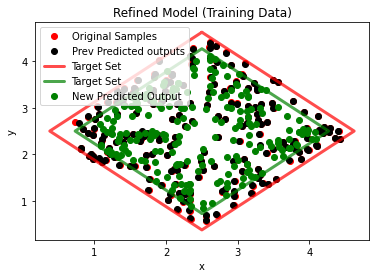

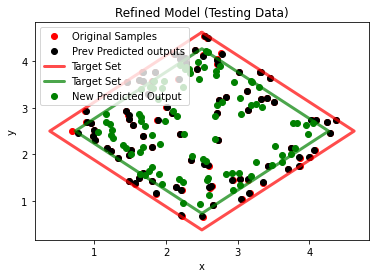

In [22]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new_train[:, 0], y_new_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new_test[:, 0], y_new_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [23]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train_last = squared_sum(y_train, y_new_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test_last = squared_sum(y_test, y_new_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Repaired NN (Last Layer)",round(MSE_new_nn_train_last,5),round(MSE_new_nn_test_last,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w2_new-w2_orig)
bias_error = np.linalg.norm(b2_new-b2_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00483,0.005
Repaired NN (Last Layer),8.53142,8.97484


weight_error: 0.5839500999066939
bias_error: 0.49766526119783505
